Paquetes necesarios

In [5]:
import cv2  
import math 

from ultralytics import YOLO
from matplotlib import pyplot as plt

## Usamos el modelo pre-entrenado de YOLO

In [ ]:
model = YOLO('yolo11n.pt')
vid = cv2.VideoCapture("./content_p4/TGC23_PdH_C0056cut.mp4")

while vid.isOpened():
    ret, frame = vid.read()

    if ret:
        results = model(frame, show=False)
        annotated_frame = results[0].plot()
        cv2.imshow("Deteccion de YOLO", annotated_frame)

        # Salir del vídeo cuando presionamos ESC
        if cv2.waitKey(1) & 0xFF == 27 or cv2.getWindowProperty("Deteccion de YOLO", cv2.WND_PROP_VISIBLE) < 1:
            break
    else:
        # El vídeo ya se terminó
        break

vid.release()
cv2.destroyAllWindows()

## Entrenamos un nuevo modelo de YOLO 


0: 640x480 1 plates, 95.8ms
Speed: 26.3ms preprocess, 95.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Text(0.5, 1.0, 'Modelo entrenado')

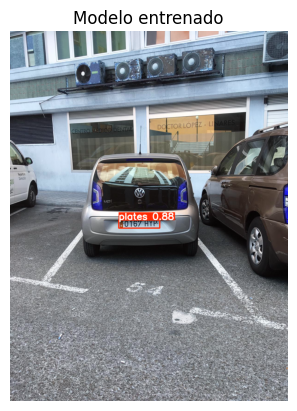

In [ ]:
model = YOLO('best.pt')

img = cv2.imread("./content_p4/matricula2.jpg")

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

results = model(img_rgb, show=False)
annotated_img = results[0].plot()

plt.imshow(annotated_img)
plt.axis("off")
plt.title("Modelo entrenado")